## 1. Data Importing

In [8]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from nucml_next.data import NucmlDataset
from nucml_next.baselines import XGBoostEvaluator, DecisionTreeEvaluator

from sklearn.model_selection import LeaveOneGroupOut, ParameterSampler
from xgboost import XGBRegressor

# Verify EXFOR data exists
exfor_path = Path('../data/exfor.parquet')
if not exfor_path.exists():
    raise FileNotFoundError(
        f"EXFOR data not found at {exfor_path}\n"
        "Please run: python scripts/ingest_exfor.py --x4-db data/x4sqlite1.db --output data/exfor_processed.parquet"
    )

print("âœ“ Imports successful")
print("âœ“ EXFOR data found")
print("Welcome to NUCML-Next: Understanding ML Limitations with Real Nuclear Data")

âœ“ Imports successful
âœ“ EXFOR data found
Welcome to NUCML-Next: Understanding ML Limitations with Real Nuclear Data


## 2. Configuration

The cell below sets three groups of options that control the rest of the
notebook:

1. **Feature tiers** -- which AME2020 / NUBASE2020 nuclear-property columns
   to include alongside the core coordinates (Z, A, N, Energy) and
   particle-emission vector.
2. **Transformation pipeline** -- log-scaling for energy and cross section,
   optional feature standardisation.
3. **Uncertainty weighting** -- whether to weight training samples by
   inverse measurement uncertainty, and how to handle missing values.

All settings are defined once here; every subsequent cell reads from these
variables.


In [2]:
# ============================================================================
# USER CONFIGURATION: Feature Tiers and Transformations
# ============================================================================
# Change these settings in ONE place instead of scattered throughout the notebook

from nucml_next.data.selection import TransformationConfig

# ============================================================================
# FEATURE TIER SELECTION
# ============================================================================
# Choose which AME2020/NUBASE2020 enrichment tiers to include
#
# Tier A (13 features) - ALWAYS INCLUDED:
#   - Z, A, N, Energy (nuclear coordinates)
#   - 9-feature Numerical Particle Vector:
#     out_n, out_p, out_a, out_g, out_f, out_t, out_h, out_d, is_met
#
# Tier B (+2 features) - Geometric:
#   + R_fm (nuclear radius)
#   + kR (dimensionless interaction parameter)
#
# Tier C (+7 features) - Energetics: RECOMMENDED FOR BASELINES
#   + Mass_Excess_MeV (mass excess)
#   + Binding_Energy_MeV (total binding energy)
#   + Binding_Per_Nucleon_MeV (B/A)
#   + S_1n_MeV, S_2n_MeV (neutron separation energies)
#   + S_1p_MeV, S_2p_MeV (proton separation energies)
#
# Tier D (+9 features) - Topological:
#   + Spin, Parity (nuclear structure)
#   + Isomer_Level, Half_Life_log10_s (log10-transformed half-life)
#   + Valence_N, Valence_P (distance to magic numbers)
#   + P_Factor (pairing: even-even/odd-odd)
#   + Shell_Closure_N, Shell_Closure_P
#
# Tier E (+8 features) - Complete Q-values:
#   + Q_alpha_MeV, Q_2beta_minus_MeV, Q_ep_MeV, etc.
#   + All 8 reaction Q-values from AME2020

SELECTED_TIERS = ['A', 'C']  # Change tiers HERE (only place to modify)

print(f"Selected Feature Tiers: {SELECTED_TIERS}")
print(f"   Features: Tier A (core + particle vector)")
print()

# ============================================================================
# TRANSFORMATION CONFIGURATION
# ============================================================================
# Configure log-scaling and feature scaling for ML training.
#
# ORDER OF OPERATIONS (forward transform):
#   1. Log-transform cross-section: sigma' = log10(sigma + epsilon)
#   2. Log-transform energy:        E' = log10(E)
#   3. Scale ALL features:          X' = (X - min) / (max - min)
#
# This ensures the scaler sees compressed log-space values rather than
# raw multi-order-of-magnitude physical values.
#
# For tree-based models (Decision Trees, XGBoost), feature scaling is NOT
# mathematically necessary because trees only use value ordering.
# However, MinMax scaling is cheap and doesn't hurt -- and it prepares
# the pipeline for neural networks where scaling IS required.

TRANSFORMATION_CONFIG = TransformationConfig(
    # ============================================================================
    # Target (cross-section) transformations
    # ============================================================================
    log_target=True,              # Enable log10 transform for cross-sections
                                  # Stabilizes gradients and handles wide range (ub to kb)
    
    target_epsilon=1e-10,         # Epsilon for log(xs + epsilon) to prevent log(0)
                                  # Increase if you have very small cross-sections
    
    log_base=10,                  # Logarithm base: 10 | 'e' | 2
                                  # Base-10 is standard in nuclear physics
    
    # ============================================================================
    # Energy transformations
    # ============================================================================
    log_energy=True,              # Enable log10 transform for energies
                                  # Handles wide energy range (eV to MeV)
    
    energy_log_base=10,           # Energy log base: 10 | 'e' | 2
    
    # ============================================================================
    # Feature standardization (MinMax, Z-score, etc.)
    # ============================================================================
    # Order: Log-transforms are applied FIRST, then feature scaling.
    # The scaler is fitted on log-transformed values, so Energy in the
    # scaler's view is log10(E), not raw eV.
    
    scaler_type='minmax',         # Feature scaling method:
                                  # 'minmax'   = Min-max scaling to [0,1] [DEFAULT]
                                  # 'standard' = Z-score normalization (X-mu)/sigma
                                  # 'robust'   = Robust scaling using median and IQR
                                  # 'none'     = No scaling
    
    scale_features='all',         # Which columns to scale:
                                  # 'all'  = Scale every numeric column [DEFAULT]
                                  # None   = Auto-detect numeric columns (same as 'all')
                                  # List   = Explicit column names, e.g. ['Z', 'A', 'Energy']
)

print("Transformation Configuration:")
print(TRANSFORMATION_CONFIG)
print()
print("NOTE: MinMax scaling applied to ALL features AFTER log-transforms.")
print("      Trees are scale-invariant, but this prepares the pipeline")
print("      for neural networks and doesn't hurt tree performance.")
print()

# ============================================================================
# UNCERTAINTY WEIGHTING CONFIGURATION
# ============================================================================
# Configure how to use experimental uncertainties during training.
#
# The EXFOR database contains measurement uncertainties for ~66% of cross-section
# values. These uncertainties can be used to weight samples during training,
# giving more influence to precise measurements and less to uncertain ones.
#
# Statistical basis: Inverse-variance weighting (w_i = 1/sigma_i^2) is the
# optimal weighting for least-squares regression when errors are heteroscedastic.

USE_UNCERTAINTY_WEIGHTS = 'xs'    # Uncertainty weighting mode:
                                  # None   = No weighting (equal weight)
                                  # 'xs'   = Weight by cross-section uncertainty (1/sigma_xs^2)
                                  # 'both' = Weight by XS AND energy uncertainty
                                  #          (1/sigma_xs^2 * 1/sigma_E^2)

MISSING_UNCERTAINTY_HANDLING = 'exclude'
                                  # How to handle samples with missing uncertainties
                                  # (only used when USE_UNCERTAINTY_WEIGHTS is not None):
                                  # 'median'  = Assign median weight from valid samples (default)
                                  # 'equal'   = Assign weight of 1.0
                                  # 'exclude' = Exclude samples without valid uncertainty
                                  #             (equivalent to requiring uncertainty)

print("=" * 80)
print("Uncertainty Weighting Configuration:")
print(f"  USE_UNCERTAINTY_WEIGHTS:       {USE_UNCERTAINTY_WEIGHTS}")
print(f"  MISSING_UNCERTAINTY_HANDLING:  '{MISSING_UNCERTAINTY_HANDLING}'")
if USE_UNCERTAINTY_WEIGHTS:
    print(f"\n  NOTE: Uncertainty weighting enabled (mode='{USE_UNCERTAINTY_WEIGHTS}').")
    print("        Samples with lower uncertainty get higher weight.")
    if MISSING_UNCERTAINTY_HANDLING == 'exclude':
        print("\n  NOTE: MISSING_UNCERTAINTY_HANDLING='exclude' will filter to only")
        print("        samples with valid uncertainty (~66% of data).")
print()
print("To change settings, modify SELECTED_TIERS and TRANSFORMATION_CONFIG above")
print("=" * 80)

Selected Feature Tiers: ['A', 'C']
   Features: Tier A (core + particle vector)

Transformation Configuration:
TransformationConfig(
  Target: log=True, base=10, epsilon=1.0e-10
  Energy: log=True, base=10
  Features: scaler=minmax
  Scale features: 'all' (every numeric column)
)

NOTE: MinMax scaling applied to ALL features AFTER log-transforms.
      Trees are scale-invariant, but this prepares the pipeline
      for neural networks and doesn't hurt tree performance.

Uncertainty Weighting Configuration:
  USE_UNCERTAINTY_WEIGHTS:       xs
  MISSING_UNCERTAINTY_HANDLING:  'exclude'

  NOTE: Uncertainty weighting enabled (mode='xs').
        Samples with lower uncertainty get higher weight.

  NOTE: MISSING_UNCERTAINTY_HANDLING='exclude' will filter to only
        samples with valid uncertainty (~66% of data).

To change settings, modify SELECTED_TIERS and TRANSFORMATION_CONFIG above


## 3. Outlier Detection & Interactive Threshold Selection

The ingested Parquet contains outlier detection results (if `--outlier-method` 
was used during ingestion). Two methods are available:

**Per-experiment method (recommended):**
- Fits independent GPs to each EXFOR experiment (Entry)
- Builds consensus to identify discrepant experiments
- Columns: `experiment_outlier`, `point_outlier`, `z_score`, `experiment_id`

**Legacy SVGP method:**
- Pools all experiments per (Z, A, MT) group
- Point-level z-scores only

The interactive explorer below lets you browse any (Z, A, MT) group, 
visualise the GP predictive distribution, adjust the z-score threshold, 
and see how inlier/outlier counts change in real time.

If the Parquet does **not** contain outlier columns, this section is skipped
automatically and all data is retained.

In [3]:
# ── Interactive Outlier Threshold Explorer ────────────────────────────────────
# Select any (Z, A, MT) group, adjust the z-score threshold, and inspect
# the GP fit + probability surface interactively.

EXFOR_DATA_PATH = '../data/exfor.parquet'

# ============================================================================
# UNCERTAINTY VISIBILITY ON PLOTS
# ============================================================================
# When True, EXFOR scatter plots will show ONLY points that have a valid
# (non-NaN, positive) cross-section uncertainty value.  This lets you
# preview exactly which measurements survive if you set
# MISSING_UNCERTAINTY_HANDLING = 'exclude' in cell 3.
#
# When False (default), all points are shown regardless of whether they
# have reported uncertainty.

PLOT_ONLY_WITH_UNCERTAINTY = False   # True  = hide points lacking XS uncertainty
                                     # False = show all points (default)

# Check for outlier detection columns (supports both per-experiment and SVGP methods)
_check_cols = ['z_score']
try:
    _raw_check = pd.read_parquet(EXFOR_DATA_PATH, columns=_check_cols)
except Exception:
    _raw_check = pd.DataFrame()

has_outlier_data = 'z_score' in _raw_check.columns and _raw_check['z_score'].notna().any()

if has_outlier_data:
    from nucml_next.visualization.threshold_explorer import ThresholdExplorer
    explorer = ThresholdExplorer(EXFOR_DATA_PATH)
    explorer.show()
else:
    print("Outlier columns not found -- run ingestion with --outlier-method to enable")
    print("  Per-experiment (recommended): --outlier-method experiment")
    print("  Legacy SVGP:                  --outlier-method svgp")
    print("\nProceeding without outlier filtering.\n")
del _raw_check

In [4]:
# ── Set outlier threshold (used by DataSelection below) ──────────────────────
# Adjust this value based on the interactive explorer above.
# Set to None to disable outlier filtering entirely.

Z_THRESHOLD = 3.0   # z-score threshold for outlier removal
                    # Used with --outlier-method experiment or svgp
                    # Recommended: 3.0 (removes ~1-2% of data in typical runs)
                    # Set to None to keep all data

# ============================================================================
print(f"Outlier z-score threshold: {Z_THRESHOLD}")
if Z_THRESHOLD is not None:
    print(f"  Points with z_score > {Z_THRESHOLD} will be excluded from training.")
    print(f"  (For per-experiment method, 'experiment_outlier' flag is also available)")
else:
    print("  Outlier filtering disabled -- all data will be used.")
print()
print(f"Plot uncertainty filter: PLOT_ONLY_WITH_UNCERTAINTY = {PLOT_ONLY_WITH_UNCERTAINTY}")
if PLOT_ONLY_WITH_UNCERTAINTY:
    print("  Plots will show ONLY points with valid cross-section uncertainty.")
    print("  This previews the training set when MISSING_UNCERTAINTY_HANDLING = 'exclude'.")
else:
    print("  Plots will show all data points (including those without uncertainty).")

Outlier z-score threshold: 3.0
  Points with z_score > 3.0 will be excluded from training.
  (For per-experiment method, 'experiment_outlier' flag is also available)

Plot uncertainty filter: PLOT_ONLY_WITH_UNCERTAINTY = False
  Plots will show all data points (including those without uncertainty).


## 4. Data: EXFOR-derived processed dataset

The notebook loads a Parquet file produced by the NUCML-Next ingestion
pipeline (`scripts/ingest_exfor.py`). A `DataSelection` object specifies
the selection constraints used here for consistency:

- **Projectile**: neutron only.
- **Energy range**: 1e-5 eV to 2e7 eV (thermal through fast reactor
  energies).
- **Reaction channels**: all physical MT codes, including bookkeeping
  channels (MT 0, 1, >= 9000).
- **Validity filter**: rows with NaN or non-positive cross sections are
  dropped so that log-transforms are well-defined.

The full training set contains all isotopes. Two evaluation isotopes are
loaded separately:

| Isotope | Reaction | Role |
|---------|----------|------|
| U-233 | Total XS (MT 1) | Data-rich: thousands of EXFOR points |
| Cl-35 | (n,p) (MT 103) | Data-sparse: tens of EXFOR points |

Comparing a data-rich and a data-sparse case illustrates how model
behaviour changes with measurement density.


In [5]:
# ============================================================================
# DATA SELECTION & LOADING
# ============================================================================
# Physics-aware selection with predicate pushdown for efficient loading.

from nucml_next.data import DataSelection
from nucml_next.experiment import HoldoutConfig, ExperimentManager, compute_holdout_metrics

print("=" * 80)
print("DATA SELECTION & LOADING")
print("=" * 80)

# ============================================================================
# PHASE-SPACE HOLDOUT CONFIGURATION
# ============================================================================
# Define holdout rules to measure extrapolation accuracy on unseen data.
# Rules are AND-intersected within, OR-unioned across (any match => holdout).
#
# Supported keys:
#   Z, A            — isotope (int)
#   MT              — reaction channel (int or list)
#   energy_range    — (E_min, E_max) in eV
#   xs_range        — (XS_min, XS_max) in barns
#   Entry           — EXFOR Entry ID(s) (str or list)
#
# Examples (uncomment to enable):
#   {'Z': 92, 'A': 233}                         — hold out ALL U-233 data
# {'Z': 92, 'A': 235, 'MT': 18}
#    'energy_range': (1e-3, 1.0)}               — U-235 capture in resonance region
#   {'MT': 18}                                  — hold out ALL fission data
#   {'xs_range': (1e-6, 1e-3)}                  — hold out low cross-section points

HOLDOUT_CONFIG = HoldoutConfig(rules=[
    # ── Uncomment rules below to enable holdout ──────────────────────────
     {'Z': 92, 'A': 235, 'MT': 18},
    # {'Z': 92, 'A': 235, 'MT': 102, 'energy_range': (1e-3, 1.0)},
    # {'MT': 18},
])

holdout_config = HOLDOUT_CONFIG if HOLDOUT_CONFIG.rules else None

if holdout_config:
    print(f"\nPhase-Space Holdout: {len(holdout_config.rules)} rule(s)")
    print(holdout_config)
else:
    print("\nPhase-Space Holdout: DISABLED")

# ============================================================================
# DATA SELECTION
# ============================================================================
training_selection = DataSelection(
    # ========================================================================
    # PROJECTILE SELECTION
    # ========================================================================
    projectile='neutron',          # Options: 'neutron' | 'all'
                                   # 'neutron' = Only neutron-induced reactions (reactor physics)
                                   # 'all' = All projectiles (n, p, d, α, γ, etc.)

    # ========================================================================
    # ENERGY RANGE (eV)
    # ========================================================================
    energy_min=1e-5,               # Minimum energy in eV (1e-5 = 0.01 eV, thermal neutrons)
    energy_max=2e7,                # Maximum energy in eV (2e7 = 20 MeV, reactor physics upper bound)
                                   # Common ranges:
                                   #   - Thermal: 1e-5 to 1 eV
                                   #   - Resonance: 1 to 1e4 eV
                                   #   - Fast: 1e4 to 2e7 eV (20 MeV)
                                   #   - High energy: up to 1e9 eV (1 GeV)

    # ========================================================================
    # REACTION (MT) MODE SELECTION
    # ========================================================================
    mt_mode='all_physical',        # Options:
                                   # 'reactor_core'   → Essential for reactor modeling
                                   #                    (MT 2, 4, 16, 18, 102, 103, 107)
                                   #                    [elastic, inelastic, (n,2n), fission,
                                   #                     capture, (n,p), (n,α)]
                                   #
                                   # 'threshold_only' → Reactions with energy thresholds
                                   #                    (MT 16, 17, 103, 104, 105, 106, 107)
                                   #                    [(n,2n), (n,3n), (n,p), (n,d), (n,t),
                                   #                     (n,³He), (n,α)]
                                   #
                                   # 'fission_details'→ Fission breakdown channels
                                   #                    (MT 18, 19, 20, 21, 38)
                                   #                    [total fission, 1st chance, 2nd chance,
                                   #                     3rd chance, 4th chance]
                                   #
                                   # 'all_physical'   → All MT codes including bookkeeping
                                   #                    (MT 0, 1, and >=9000 now INCLUDED)
                                   #
                                   # 'custom'         → Use custom_mt_codes list (see below)

    # ========================================================================
    # EXCLUSION RULES
    # ========================================================================
    exclude_bookkeeping=False,     # Set to False to INCLUDE MT 0, 1, and MT >= 9000
                                   # MT 0 = Undefined
                                   # MT 1 = Total cross-section (sum of others)
                                   # MT >= 9000 = Lumped reaction covariances

    # ========================================================================
    # DATA VALIDITY
    # ========================================================================
    drop_invalid=True,             # Drop NaN or non-positive cross-sections
                                   # Essential for log-transform: log(σ) requires σ > 0
                                   # Prevents training instabilities

    # ========================================================================
    # PHASE-SPACE HOLDOUT
    # ========================================================================
    holdout_config=holdout_config, # HoldoutConfig with intersection/union rule logic
                                   # Replaces the legacy holdout_isotopes parameter
                                   # Set to None to disable holdout filtering

    # ========================================================================
    # AME2020/NUBASE2020 ENRICHMENT TIER SELECTION
    # ========================================================================
    tiers=SELECTED_TIERS,          # Using centralized tier configuration from cell 3
    transformation_config=TRANSFORMATION_CONFIG,  # Using centralized transformation config

    # ========================================================================
    # OUTLIER FILTERING (from SVGP detection, if available)
    # ========================================================================
    z_threshold=Z_THRESHOLD,       # Z-score threshold from cell 6 (None = no filtering)
    include_outliers=Z_THRESHOLD is None,  # Remove outliers when threshold is set
)

print("\n" + "-" * 80)
print("Training Selection:")
print(training_selection)

# ============================================================================
# LOAD DATASET
# ============================================================================
print("\n" + "-" * 80)
print("Loading dataset with predicate pushdown...")
dataset_full = NucmlDataset(
    data_path='../data/exfor.parquet',
    mode='tabular',
    selection=training_selection,
)

# Retrieve holdout data (if configured)
df_holdout = dataset_full.get_holdout_data()
if df_holdout is not None:
    print(f"\n[OK] Holdout reserved: {len(df_holdout):,} points "
          f"({df_holdout.groupby(['Z','A']).ngroups} isotopes)")
else:
    print("\n[--] No holdout data")

# ============================================================================
# PROJECT TO TABULAR FORMAT
# ============================================================================
print("\n" + "-" * 80)
print("Projecting to tabular format (particle vector)...")
_extra_meta = ['Energy_Uncertainty'] if USE_UNCERTAINTY_WEIGHTS == 'both' else None
df_tier = dataset_full.to_tabular(extra_metadata=_extra_meta)

print(f"\n[OK] Training set: {len(df_tier):,} samples x {len(df_tier.columns)} columns")
print(f"     Energy range: {df_tier['Energy'].min():.2e} – {df_tier['Energy'].max():.2e} eV")

# ============================================================================
# UNCERTAINTY COVERAGE SUMMARY
# ============================================================================
if 'Uncertainty' in df_tier.columns:
    valid_unc = df_tier['Uncertainty'].notna() & (df_tier['Uncertainty'] > 0)
    pct = 100 * valid_unc.sum() / len(df_tier)
    print(f"     XS uncertainty: {valid_unc.sum():,} / {len(df_tier):,} ({pct:.1f}%)")

# ============================================================================
# FEATURE SUMMARY
# ============================================================================
print("\n" + "-" * 80)
print(f"Feature Tiers: {SELECTED_TIERS}")
TIER_NAMES = {'A': 'Core+Particle', 'B': 'Geometric', 'C': 'Energetics',
              'D': 'Topological', 'E': 'Q-values'}
for t in SELECTED_TIERS:
    print(f"  Tier {t}: {TIER_NAMES.get(t, 'Unknown')}")

# ============================================================================
# DATA DISTRIBUTION
# ============================================================================
print("\n" + "-" * 80)
print("Top 10 Isotopes:")
for (z, a), cnt in dataset_full.df.groupby(['Z', 'A']).size().nlargest(10).items():
    elem = {92:'U', 17:'Cl', 94:'Pu', 26:'Fe', 8:'O', 1:'H', 82:'Pb',
            6:'C', 13:'Al', 7:'N', 11:'Na', 79:'Au'}.get(z, f'Z{z}')
    print(f"  {elem}-{a:3d}: {cnt:>8,}")

print(f"\nTotal: {dataset_full.df.groupby(['Z','A']).ngroups} isotopes, "
      f"{dataset_full.df['MT'].nunique()} MT codes, {len(dataset_full.df):,} points")

# ============================================================================
# LOAD EVALUATION ISOTOPES (U-233, Cl-35)
# ============================================================================
print("\n" + "-" * 80)
print("Loading evaluation targets (U-233, Cl-35)...")
eval_selection = DataSelection(
    projectile='neutron',
    energy_min=training_selection.energy_min,
    energy_max=training_selection.energy_max,
    mt_mode=training_selection.mt_mode,
    exclude_bookkeeping=training_selection.exclude_bookkeeping,
    drop_invalid=True,
    tiers=SELECTED_TIERS,
)

dataset_eval = NucmlDataset(
    data_path='../data/exfor.parquet',
    mode='tabular',
    selection=eval_selection,
)
dataset_eval.df = dataset_eval.df[
    ((dataset_eval.df['Z'] == 92) & (dataset_eval.df['A'] == 233)) |
    ((dataset_eval.df['Z'] == 17) & (dataset_eval.df['A'] == 35))
].copy()

print(f"[OK] Evaluation set: {len(dataset_eval.df):,} points")
for (z, a), grp in dataset_eval.df.groupby(['Z', 'A']):
    iso = 'U' if z == 92 else 'Cl'
    print(f"     {iso}-{a}: {len(grp):,} (MT: {sorted(grp['MT'].unique())})")
print("=" * 80)

DATA SELECTION & LOADING

Phase-Space Holdout: 1 rule(s)
HoldoutConfig(
  Rule 1: Z=92, A=235, MT=18
)

--------------------------------------------------------------------------------
Training Selection:
DataSelection(
  Projectile: neutron
  Energy: 1.00e-05 - 2.00e+07 eV
  MT mode: all_physical
  MT codes: all physical (including MT 0 undefined)
  Feature tiers: ['A', 'C']
  Transformations: log_target=True, log_energy=True, scaler=minmax
  Holdout: 1 rule(s)
    Rule 1: {'Z': 92, 'A': 235, 'MT': 18}
  Outlier filter: z_threshold=3.0, action=remove
  Drop invalid: True
)

--------------------------------------------------------------------------------
Loading dataset with predicate pushdown...

Loading data from ../data/exfor.parquet...
  Reading Parquet file...
  [*] Reading Parquet file...
  [OK] Read complete: 0.4s, 1.43 GB
  [*] Converting to Pandas...
  [OK] Conversion complete: 0.2s
  [OK] Total load time: 0.7s

Applying post-load filters...
  [OK] Projectile filter (neutrons)

INFO: Loading AME2020/NUBASE2020 data files...
INFO: Loading mass_1.mas20.txt...
INFO: Loaded 3558 isotopes from mass_1.mas20.txt
INFO: Loading rct1.mas20.txt...
INFO: Loaded 3558 isotopes from rct1.mas20.txt
INFO: Loading rct2_1.mas20.txt...
INFO: Loaded 3558 isotopes from rct2_1.mas20.txt
INFO: Loading nubase_4.mas20.txt...
INFO: Loaded 5820 ground-state isotopes from nubase_4.mas20.txt


  Summary: 13,419,082 -> 9,604,296 (71.6% retained)

[OK] Loaded 9,604,296 EXFOR data points from ../data/exfor.parquet

  Loading AME2020/NUBASE2020 data for tiers ['A', 'C']...
  Found AME files in: ../data
  Loading all AME2020/NUBASE2020 files into memory...


INFO: Applied isomer fallback: Added 2262 isomeric states with inherited AME properties
INFO: Loaded 5820 isotopes with enrichment data


  Merging AME data with EXFOR measurements...
    Filtered to 3558 ground-state isotopes (Isomer_Level == 0)


INFO: Loading AME2020/NUBASE2020 data files...
INFO: Loading mass_1.mas20.txt...
INFO: Loaded 3558 isotopes from mass_1.mas20.txt
INFO: Loading rct1.mas20.txt...
INFO: Loaded 3558 isotopes from rct1.mas20.txt
INFO: Loading rct2_1.mas20.txt...
INFO: Loaded 3558 isotopes from rct2_1.mas20.txt
INFO: Loading nubase_4.mas20.txt...
INFO: Loaded 5820 ground-state isotopes from nubase_4.mas20.txt


  [OK] Added 19 AME enrichment columns
  [OK] Coverage: 9,604,296 / 9,604,296 (100.0%) measurements enriched


  Loading AME2020/NUBASE2020 data for tiers ['A', 'C']...
  Found AME files in: ../data
  Loading all AME2020/NUBASE2020 files into memory...


INFO: Applied isomer fallback: Added 2262 isomeric states with inherited AME properties
INFO: Loaded 5820 isotopes with enrichment data


  Merging AME data with EXFOR measurements...
    Filtered to 3558 ground-state isotopes (Isomer_Level == 0)
  [OK] Added 19 AME enrichment columns
  [OK] Coverage: 187,467 / 187,467 (100.0%) measurements enriched


[OK] Holdout reserved: 187,467 points (1 isotopes)

--------------------------------------------------------------------------------
Projecting to tabular format (particle vector)...

[OK] Training set: 9,604,296 samples x 24 columns
     Energy range: 1.02e-05 – 1.00e+09 eV
     XS uncertainty: 8,342,321 / 9,604,296 (86.9%)

--------------------------------------------------------------------------------
Feature Tiers: ['A', 'C']
  Tier A: Core+Particle
  Tier C: Energetics

--------------------------------------------------------------------------------
Top 10 Isotopes:
  U-238:  545,255
  Z93-237:  287,430
  Pu-239:  275,564
  Pu-240:  243,208
  Z53-127:  210,440
  U-235:  204,978
  U-233:  202,899
  Pb-206:  197,855
  Z90-232:  189,048
  Z28- 58:  186,361

Total: 549 is

INFO: Loading AME2020/NUBASE2020 data files...
INFO: Loading mass_1.mas20.txt...
INFO: Loaded 3558 isotopes from mass_1.mas20.txt
INFO: Loading rct1.mas20.txt...
INFO: Loaded 3558 isotopes from rct1.mas20.txt
INFO: Loading rct2_1.mas20.txt...
INFO: Loaded 3558 isotopes from rct2_1.mas20.txt
INFO: Loading nubase_4.mas20.txt...
INFO: Loaded 5820 ground-state isotopes from nubase_4.mas20.txt


  Summary: 13,419,082 -> 9,925,554 (74.0% retained)

[OK] Loaded 9,925,554 EXFOR data points from ../data/exfor.parquet

  Loading AME2020/NUBASE2020 data for tiers ['A', 'C']...
  Found AME files in: ../data
  Loading all AME2020/NUBASE2020 files into memory...


INFO: Applied isomer fallback: Added 2262 isomeric states with inherited AME properties
INFO: Loaded 5820 isotopes with enrichment data


  Merging AME data with EXFOR measurements...
    Filtered to 3558 ground-state isotopes (Isomer_Level == 0)
  [OK] Added 19 AME enrichment columns
  [OK] Coverage: 9,925,554 / 9,925,554 (100.0%) measurements enriched

[OK] Evaluation set: 209,997 points
     Cl-35: 3,687 (MT: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(16), np.int64(102), np.int64(103), np.int64(107), np.int64(151), np.int64(601), np.int64(651), np.int64(801), np.int64(6001), np.int64(6002), np.int64(6003), np.int64(6010), np.int64(6021), np.int64(6022), np.int64(6023), np.int64(6024), np.int64(6031), np.int64(9000)])
     U-233: 206,310 (MT: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(16), np.int64(18), np.int64(27), np.int64(51), np.int64(101), np.int64(102), np.int64(107), np.int64(151), np.int64(452), np.int64(454), np.int64(455), np.int64(456), np.int64(458), np.int64(459), np.int64(1016), np.int64(6001), np.int64(6003), np.int64(6004), np.int64(6010), np.int64(602

## 5. Dataset Transforms

In [6]:
df_main = df_tier.copy()

In [7]:
#Apply log10 transforms to energy and cross-section.
df_main['Energy'] = np.log10(df_main['Energy'] + 1e-10)
df_main['CrossSection'] = np.log10(df_main['CrossSection'] + 1e-10)

# Model Tuning

In [9]:
# Create target and feature tables
X = df_main.drop(columns=['CrossSection', 'Entry', 'MT', 'Uncertainty'])
y = df_main['CrossSection']

In [31]:
# --- settings ---
Z0, A0 = 92, 235
act_Z_min, act_Z_max = 89, 103     # actinides
K_nuclides = 50                    # how many nearby actinide nuclides to include
n_outer_nuclides = 15              # nuclides reserved for outer validation (disjoint from tuning)
wZ, wA = 10.0, 1.0                 # distance weights

rng = np.random.default_rng(0)

# --- 1) restrict df_main to actinides ---
act_mask = df_main["Z"].between(act_Z_min, act_Z_max)
df_act = df_main.loc[act_mask].copy()

# --- 2) pick nearby NUCLIDES (Z,A) ---
nuclides = df_act[["Z","A"]].drop_duplicates().copy()
nuclides["d"] = np.sqrt((wZ*(nuclides["Z"]-Z0))**2 + (wA*(nuclides["A"]-A0))**2)

near_nuclides = nuclides.sort_values("d").head(K_nuclides)[["Z","A"]]

# include ALL MTs for these nuclides (row mask on df_main / X_main / y_main)
near_pairs = set(map(tuple, near_nuclides.to_numpy()))
nuclide_all = list(zip(df_main["Z"].to_numpy(), df_main["A"].to_numpy()))
near_row_mask = np.fromiter((za in near_pairs for za in nuclide_all), dtype=bool)
near_row_mask &= act_mask.to_numpy()

# --- 3) split by NUCLIDE into tuning vs outer-validation nuclides ---
near_labels = np.array(list(near_pairs), dtype=object)
rng.shuffle(near_labels)

outer_nuclides = set(map(tuple, near_labels[:n_outer_nuclides]))
tune_nuclides  = set(map(tuple, near_labels[n_outer_nuclides:]))

outer_row_mask = np.fromiter(((z,a) in outer_nuclides for z,a in nuclide_all), dtype=bool) & near_row_mask
tune_row_mask  = np.fromiter(((z,a) in tune_nuclides  for z,a in nuclide_all), dtype=bool) & near_row_mask

# --- 4) LOGO groups are (Z,A,MT) ---
groups_main = pd.factorize(pd.MultiIndex.from_frame(df_main[["Z","A","MT"]]))[0]

X_tune,  y_tune,  g_tune  = X.loc[tune_row_mask],  np.asarray(y)[tune_row_mask],  groups_main[tune_row_mask]
X_outer, y_outer, g_outer = X.loc[outer_row_mask], np.asarray(y)[outer_row_mask], groups_main[outer_row_mask]


def cap_rows_per_group_binned(
    X_sub: pd.DataFrame,
    y_sub,
    g_sub,
    x_col: str = "Energy",   # already log(E)
    max_rows: int = 3000,
    n_bins: int = 200,
    seed: int = 0,
):
    """
    Cap each group (g_sub) to at most max_rows by sampling evenly across bins of X_sub[x_col].
    Assumes x_col is already log-energy.
    """
    rng = np.random.default_rng(seed)

    if x_col not in X_sub.columns:
        raise KeyError(f"'{x_col}' not found in X_sub columns.")

    y_arr = np.asarray(y_sub)
    g_arr = np.asarray(g_sub)

    pos = np.arange(len(X_sub))
    tmp = pd.DataFrame({"pos": pos, "g": g_arr})

    keep_pos_all = []

    for _, block in tmp.groupby("g", sort=False):
        block_pos = block["pos"].to_numpy()
        n = block_pos.size
        if n <= max_rows:
            keep_pos_all.append(block_pos)
            continue

        x = X_sub.iloc[block_pos][x_col].to_numpy()
        ok = np.isfinite(x)
        if ok.sum() < 2:
            keep_pos_all.append(rng.choice(block_pos, size=max_rows, replace=False))
            continue

        lo = np.nanmin(x[ok])
        hi = np.nanmax(x[ok])
        if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
            keep_pos_all.append(rng.choice(block_pos, size=max_rows, replace=False))
            continue

        edges = np.linspace(lo, hi, n_bins + 1)
        bin_id = np.digitize(x, edges) - 1
        bin_id = np.clip(bin_id, 0, n_bins - 1)

        target_per_bin = max_rows // n_bins
        remainder = max_rows - target_per_bin * n_bins

        keep_pos = []
        for b in range(n_bins):
            in_bin = block_pos[bin_id == b]
            if in_bin.size == 0:
                continue
            take = target_per_bin + (1 if b < remainder else 0)
            if in_bin.size <= take:
                keep_pos.append(in_bin)
            else:
                keep_pos.append(rng.choice(in_bin, size=take, replace=False))

        keep_pos = np.concatenate(keep_pos) if keep_pos else rng.choice(block_pos, size=max_rows, replace=False)

        # top up if we ended short due to empty bins
        if keep_pos.size < max_rows:
            remaining = np.setdiff1d(block_pos, keep_pos, assume_unique=False)
            if remaining.size > 0:
                add = rng.choice(remaining, size=min(max_rows - keep_pos.size, remaining.size), replace=False)
                keep_pos = np.concatenate([keep_pos, add])

        # trim if needed
        if keep_pos.size > max_rows:
            keep_pos = rng.choice(keep_pos, size=max_rows, replace=False)

        keep_pos_all.append(keep_pos)

    keep_pos_all = np.concatenate(keep_pos_all)
    keep_pos_all = np.sort(keep_pos_all)  # keep original order

    X_cap = X_sub.iloc[keep_pos_all]
    y_cap = y_arr[keep_pos_all]
    g_cap = g_arr[keep_pos_all]
    return X_cap, y_cap, g_cap

X_tune, y_tune, g_tune = cap_rows_per_group_binned(
    X_tune, y_tune, g_tune,
    x_col="Energy",
    max_rows=3000,
    n_bins=200,
    seed=0
)

X_outer, y_outer, g_outer = cap_rows_per_group_binned(
    X_outer, y_outer, g_outer,
    x_col="Energy",
    max_rows=8000,
    n_bins=300,
    seed=1
)

print("After capping:")
print(" tune rows:", len(X_tune), "tune groups:", np.unique(g_tune).size)
print(" outer rows:", len(X_outer), "outer groups:", np.unique(g_outer).size)

# --- 5) OPTIONAL: drop tiny (Z,A,MT) groups for CV stability/speed ---
min_group_size = 50  # choose 20/50/100

def filter_small_groups(X_sub, y_sub, g_sub, min_size):
    uniq, counts = np.unique(g_sub, return_counts=True)
    keep_groups = set(uniq[counts >= min_size])
    keep_mask = np.fromiter((gi in keep_groups for gi in g_sub), dtype=bool)
    return X_sub.loc[keep_mask], np.asarray(y_sub)[keep_mask], g_sub[keep_mask]

X_tune, y_tune, g_tune = filter_small_groups(X_tune, y_tune, g_tune, min_group_size)
X_outer, y_outer, g_outer = filter_small_groups(X_outer, y_outer, g_outer, min_group_size)

print("After filtering:")
print("  tune rows:", len(X_tune), "tune groups:", np.unique(g_tune).size)
print("  outer rows:", len(X_outer), "outer groups:", np.unique(g_outer).size)


After capping:
 tune rows: 158627 tune groups: 313
 outer rows: 193283 outer groups: 166
After filtering:
  tune rows: 156886 tune groups: 154
  outer rows: 192491 outer groups: 97


In [ ]:
from sklearn.model_selection import LeaveOneGroupOut, ParameterSampler
from xgboost import XGBRegressor

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

logo = LeaveOneGroupOut()

# Define a search space (edit to taste)
param_space = {
    # Core capacity / smoothness vs sharpness
    "max_depth":          [6, 8, 10, 12, 14],
    "min_child_weight":   [0.5, 1, 2, 3, 5],
    "gamma":              [0, 0.01, 0.05, 0.1, 0.2],

    # Learning dynamics
    "learning_rate":      [0.01, 0.02, 0.03, 0.05, 0.1],

    # Stochasticity (can help generalization but too low can wash out rare peaks)
    "subsample":          [0.7, 0.8, 0.9, 1.0, 0.6],
    "colsample_bytree":   [0.6, 0.7, 0.8, 0.9, 1.0],

    # Regularization (don’t over-penalize if you want narrow structure)
    "reg_lambda":         [0.0, 0.1, 0.5, 1.0, 2.0],
    "reg_alpha":          [0.0, 1e-4, 1e-3, 1e-2, 1e-1],

    # Histogram binning can matter for narrow features in E
    "tree_method":        ["hist", "hist", "hist", "approx", "exact"],
    "max_bin":            [256, 512, 1024, 2048, 4096],

    # Make this explicit so you don't accidentally go linear
    "booster":            ["gbtree", "gbtree", "gbtree", "dart", "gbtree"],
}

base_kwargs = dict(
    objective="reg:squarederror",
    n_estimators=1000,      # use large + early stopping to find good boosting rounds
    n_jobs=-1,
    random_state=0,
)

n_iter = 25  # increase if you can afford it
candidates = list(ParameterSampler(param_space, n_iter=n_iter, random_state=0))

best_params = None
best_score = np.inf

X_t = X_tune
y_t = np.asarray(y_tune)

for i, params in enumerate(candidates, 1):
    fold_scores = []

    for tr_idx, te_idx in logo.split(X_t, y_t, groups=g_tune):
        X_tr, y_tr = X_t.iloc[tr_idx], y_t[tr_idx]
        X_te, y_te = X_t.iloc[te_idx], y_t[te_idx]

        model = XGBRegressor(**base_kwargs, **params)

        # Early stopping uses the held-out fold as eval_set (OK for tuning)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_te, y_te)],
            verbose=False,
        )

        pred = model.predict(X_te)
        fold_scores.append(rmse(y_te, pred))

    mean_score = float(np.mean(fold_scores))
    print(f"[{i:02d}/{n_iter}] mean LOGO RMSE = {mean_score:.5g}  params={params}")

    if mean_score < best_score:
        best_score = mean_score
        best_params = params

    # exactly n_iter prints
    print(f"[{i:02d}/{n_iter}] best_so_far RMSE={best_score:.5g}  best_params={best_params}")

print("\nFinal best inner-LOGO RMSE:", best_score)
print("Final best params:", best_params)

In [30]:
import numpy as np

n_rows = len(X_tune)
n_groups = np.unique(g_tune).size   # LOGO folds
print("Tuning rows:", n_rows)
print("Unique (Z,A,MT) groups in tuning:", n_groups)
print("Total model fits (random search):", n_groups * n_iter)

Tuning rows: 156886
Unique (Z,A,MT) groups in tuning: 154
Total model fits (random search): 3850


# Model Prediction and Plotting

In [33]:
df_hold = df_holdout.copy()

In [34]:
#Apply log10 transforms to energy and cross-section.
df_hold['Energy'] = np.log10(df_hold['Energy'] + 1e-10)
df_hold['CrossSection'] = np.log10(df_hold['CrossSection'] + 1e-10)

In [35]:
# Create target and feature tables
X_hold = df_hold.drop(columns=['CrossSection', 'Entry', 'MT', 'Uncertainty'])
y_hold = df_hold['CrossSection']

In [37]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
y_hold_pred = model.predict(X_hold)

# Metrics
mse = mean_squared_error(y_hold, y_hold_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_hold, y_hold_pred)
r2 = r2_score(y_hold, y_hold_pred)

print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")

RMSE: 1.5442 | MAE: 1.2713 | R2: -0.4211


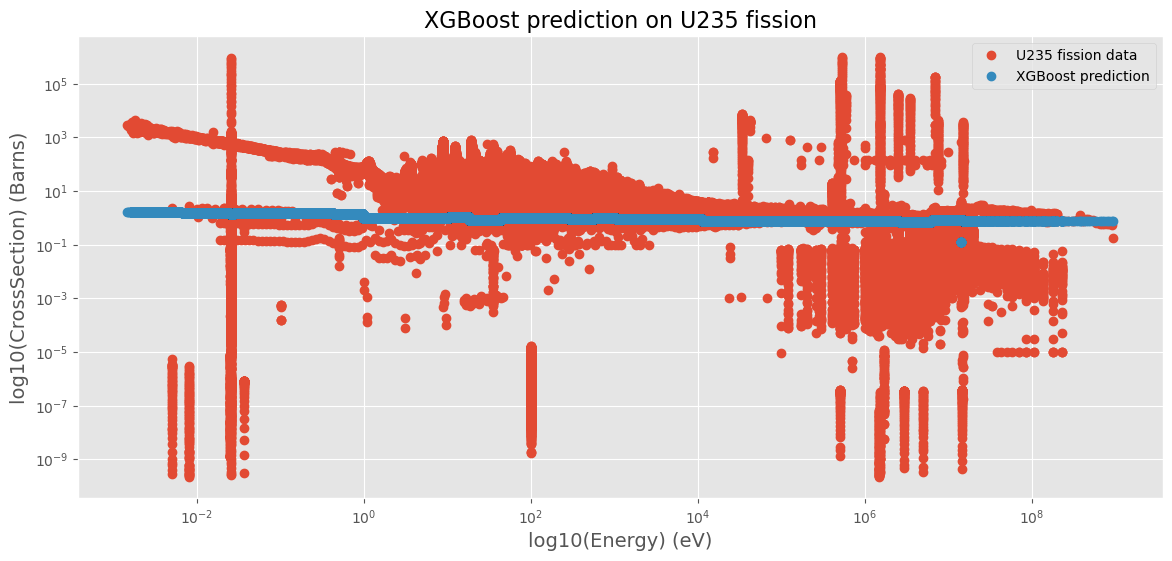

In [97]:
plt.style.use("ggplot")

fig, ax = plt.subplots(figsize=(14, 6))

x = X_hold["Energy"].to_numpy()
y = y_hold_pred

mask = np.isfinite(x) & np.isfinite(y)   # optional but recommended
x2, y2 = x[mask], y[mask]

idx = np.argsort(x2)
x_sorted = x2[idx]
y_sorted = y2[idx]

ax.plot(10**x2, 10**y_hold, 'o', label="U235 fission data")
ax.plot(10**x2, 10**y2, 'o', label="XGBoost prediction")

ax.set_xlabel("log10(Energy) (eV)", fontsize=14)
ax.set_ylabel("log10(CrossSection) (Barns)", fontsize=14)
ax.set_title("XGBoost prediction on U235 fission", fontsize=16)
ax.set_xscale("log")
ax.set_yscale("log")



ax.legend()
plt.savefig("xgb1.png")
plt.show()